# Mixture Models


When creating models I find it easiest to start simple. Here we'll try to classify the Palmer Penguin dataset using only one feature.


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

import altair as alt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
penguin_df = (
    pd.read_csv("./data/penguins_size.csv").drop(columns=["island", "sex"]).dropna()
)
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


<IPython.core.display.Javascript object>

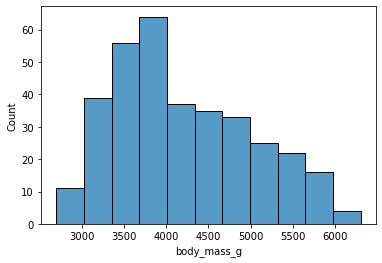

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(penguin_df.body_mass_g)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_penguin_df = scaler.fit_transform(penguin_df.drop(columns=["species"]))
scaled_penguin_df = pd.DataFrame(scaled_penguin_df, columns=penguin_df.columns[1:])
scaled_penguin_df["species"] = list(penguin_df["species"])
scaled_penguin_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.884499,0.785449,-1.418347,-0.564142,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,Adelie
...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,Gentoo


<IPython.core.display.Javascript object>

In [5]:
scaled_penguin_df.groupby(["species"]).agg(
    mean_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="mean"),
    std_culmen_length=pd.NamedAgg(column="culmen_length_mm", aggfunc="std"),
    mean_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="mean"),
    std_culmen_depth=pd.NamedAgg(column="culmen_depth_mm", aggfunc="std"),
    mean_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="mean"),
    std_flipper_length=pd.NamedAgg(column="flipper_length_mm", aggfunc="std"),
    mean_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="mean"),
    std_body_mass=pd.NamedAgg(column="body_mass_g", aggfunc="std"),
)

,mean_culmen_length,std_culmen_length,mean_culmen_depth,std_culmen_depth,mean_flipper_length,std_flipper_length,mean_body_mass,std_body_mass
species,,,,,,,,
Adelie,-0.941108,0.488555,0.606109,0.616992,-0.780675,0.465735,-0.625754,0.572648
Chinstrap,0.901001,0.612528,0.643753,0.575786,-0.362625,0.507928,-0.585261,0.479950
Gentoo,0.657229,0.565313,-1.099980,0.497600,1.158865,0.461855,1.091761,0.629531


<IPython.core.display.Javascript object>

In [6]:
n_clusters = 3
n_observations, n_features = scaled_penguin_df.shape

with pm.Model() as model:
    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    bm_sigmas = pm.HalfNormal("bm_sigmas", sigma=1, shape=n_clusters)
    bm_means = pm.Normal("bm_means", np.zeros(n_clusters), sd=1, shape=n_clusters)

    y_bm = pm.Normal(
        "y_bm",
        mu=bm_means[category],
        sd=bm_sigmas[category],
        observed=scaled_penguin_df.body_mass_g,
    )

    trace = pm.sample(10000)

<ipython-input-6-894b747cbfcf>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [bm_means, bm_sigmas, p]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 480 seconds.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050429870441972, but should be close to 0.8. Try to increase the number of tuning steps.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6982307827482005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8979412098339185, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective sampl

<IPython.core.display.Javascript object>

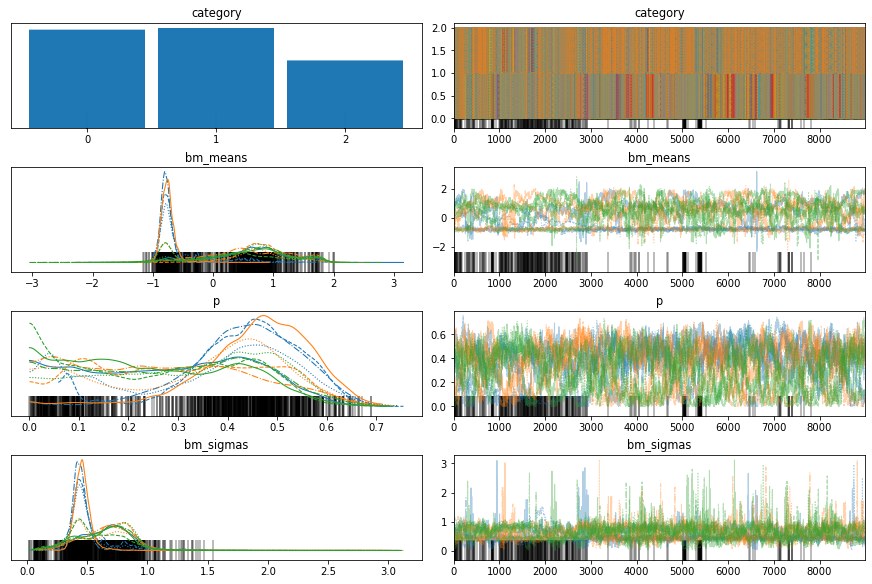

<IPython.core.display.Javascript object>

In [7]:
with model:
    pm.plot_trace(trace[1000:])

In [8]:
groups = [
    f"Group {n+1}"
    for n in list(trace.get_values("category", burn=6000, combine=False)[2][20])
]
penguin_df["group"] = groups
penguin_df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,group
0,Adelie,39.1,18.7,181.0,3750.0,Group 1
1,Adelie,39.5,17.4,186.0,3800.0,Group 1
2,Adelie,40.3,18.0,195.0,3250.0,Group 1
4,Adelie,36.7,19.3,193.0,3450.0,Group 1
5,Adelie,39.3,20.6,190.0,3650.0,Group 2
...,...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0,Group 2
340,Gentoo,46.8,14.3,215.0,4850.0,Group 2
341,Gentoo,50.4,15.7,222.0,5750.0,Group 2
342,Gentoo,45.2,14.8,212.0,5200.0,Group 2


<IPython.core.display.Javascript object>

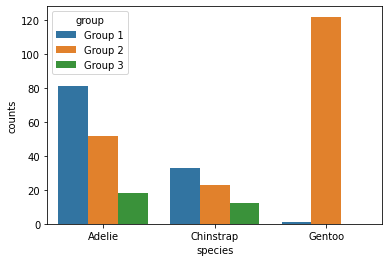

<IPython.core.display.Javascript object>

In [19]:
plot_df = penguin_df.groupby(["species", "group"]).size().reset_index(name="counts")

_ = sns.barplot(data=plot_df, x="species", y="counts", hue="group")

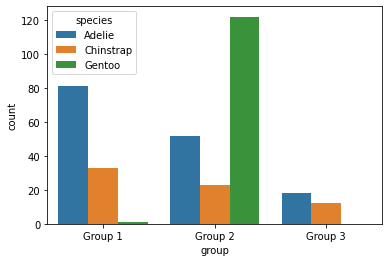

<IPython.core.display.Javascript object>

In [10]:
_ = sns.barplot(data=plot_df, x="group", y="counts", hue="species")

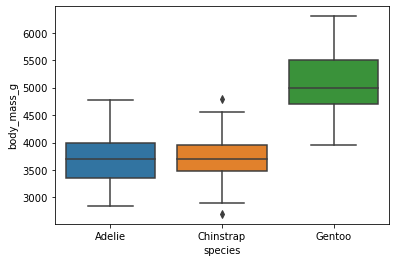

<IPython.core.display.Javascript object>

In [11]:
_ = sns.boxplot(data=penguin_df, x="species", y="body_mass_g")

In [21]:
alt.Chart(plot_df).mark_bar().encode(
    x=alt.X("group", title=None),
    y=alt.Y("counts", title="Count"),
    color=alt.Color("species", title="Species"),
    tooltip=["group", "counts", "species"],
).properties(width=400)

alt.Chart(...)

<IPython.core.display.Javascript object>

Taking only the weight of the birds into account we can classify them correctly to some extent, but the model is making a lot of mistakes. Especially the smaller individuals (Adelie and Chinstrap and smaller Gentoos) are often confused. The model also has a ton of issues, so it is clear we can and should do a better job.